In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import MySQLdb
from sqlalchemy import create_engine

import tools.feature_selection as fs
import tools.preprocessing as ps
import tools.evaluations as ev

## Data Import

### Import data from Database

In [4]:
host = 'db1.ceobypqfxmry.us-east-2.rds.amazonaws.com'
port = '3306'
db = 'db'
user = 'admin'
password = 'msbd5001'
tb = 'bur_attr_target'
engine = create_engine(str(r"mysql+mysqldb://%s:" + '%s' + "@%s/%s") % (user, password, host, db))

In [5]:
df_train = pd.read_sql_table(tb, engine)
df_train.head()

,SK_ID_CURR,SK_ID_CURR1,CREDIT_CURRENCY_currency_1,CREDIT_CURRENCY_currency_2,CREDIT_CURRENCY_currency_3,CREDIT_CURRENCY_currency_4,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_Bad_debt,...,bureau_AMT_CREDIT_SUM_OVERDUE_std,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_avg,bureau_DAYS_CREDIT_UPDATE_std,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_avg,bureau_AMT_ANNUITY_std,TARGET
0,100002,100002.0,1.0,0.0,0.0,0.0,0.75,0.25,0.0,0.0,...,0.0,-1185.0,-7.0,-499.875,485.033359,0.0,0.0,0.0,0.0,1
1,100003,100003.0,1.0,0.0,0.0,0.0,0.75,0.25,0.0,0.0,...,0.0,-2131.0,-43.0,-816.000,786.397800,NaN,NaN,NaN,NaN,0
2,100004,100004.0,1.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,...,0.0,-682.0,-382.0,-532.000,150.000000,NaN,NaN,NaN,NaN,0
3,100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,100007.0,1.0,0.0,0.0,0.0,1.00,0.00,0.0,0.0,...,0.0,-783.0,-783.0,-783.000,0.000000,NaN,NaN,NaN,NaN,0


In [6]:
# save data as csv file
df_train.to_csv('./data/bur_attr_target.csv', index=False)

### Import data from csv file

In [2]:
#f_train = pd.read_csv('./data/pa_attr.csv')
df_train = pd.read_csv(r'E:\zgr\HKUST\MSBD5001\project\home-credit-default-risk\application_train.csv')

## Data Profiling

In [9]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(df_train, check_correlation=False)
profile.to_file('./data_profile/pa_attr.html')

## Data Processing

### Separating continuous and categorical variables

In [11]:
# Separating continuous and categorical variables (setting yout own rule)
cate_vars = []
cont_vars = []
for col in df_train.columns:
    if col not in ['SK_ID_CURR','SK_ID_CURR1','TARGET']:
        if df_train[col].dtype in ['float64','int64'] and df_train[col].nunique() > 3:
            cont_vars.append(col)
        else:
            cate_vars.append(col)

In [4]:
# Encoding categorical variables
df_train = ps.cate_enc(df_train, cate_vars)

### Missing Values

In [12]:
df_train.fillna(0xDEADBEEF, inplace=True) 

## Feature Selection

In [13]:
df_train_woe = df_train.copy()
df_train_woe['target'] = df_train_woe['TARGET']
df_train_woe.drop('TARGET',axis=1,inplace=True)

In [14]:
df_train_woe.shape

(307511, 78)

In [15]:
df_iv = fs.cal_iv(df_train_woe,cate_vars,cont_vars,'target')

-process discrete variable:CREDIT_TYPE_Mobile_operator_loan-
---process discrete variable:CREDIT_TYPE_Interbank_credit---
------process discrete variable:bureau_SK_ID_CURR_std-------
---process continuous variable:CREDIT_CURRENCY_currency_1---
---process continuous variable:CREDIT_CURRENCY_currency_2---
---process continuous variable:CREDIT_CURRENCY_currency_3---
---process continuous variable:CREDIT_CURRENCY_currency_4---
------process continuous variable:CREDIT_ACTIVE_Closed------
------process continuous variable:CREDIT_ACTIVE_Active------
-------process continuous variable:CREDIT_ACTIVE_Sold-------
-----process continuous variable:CREDIT_ACTIVE_Bad_debt-----
process continuous variable:CREDIT_TYPE_Unknown_type_of_loan
--process continuous variable:CREDIT_TYPE_Real_estate_loan--
------process continuous variable:CREDIT_TYPE_Mortgage------
-----process continuous variable:CREDIT_TYPE_Microloan------
process continuous variable:CREDIT_TYPE_Loan_for_working_capital_replenishment
proces

In [16]:
df_iv.to_excel('./features/df_bur_attr_iv.xlsx',index=False)

In [10]:
df_iv = pd.read_excel('./features/df_train_iv.xlsx')
iv_features_train = df_iv[df_iv['iv']>0.02]['var_name'].values

## Modeling

In [6]:
# fill in missing values.
df_train.fillna(-1,inplace=True)

In [11]:
# encoding TARGET
df_train['TARGET'] = df_train['TARGET'].astype('category')

In [12]:
# split dataset
X_train, X_test, y_train, y_test = ps.split_data(df_train,iv_features_train,'TARGET')

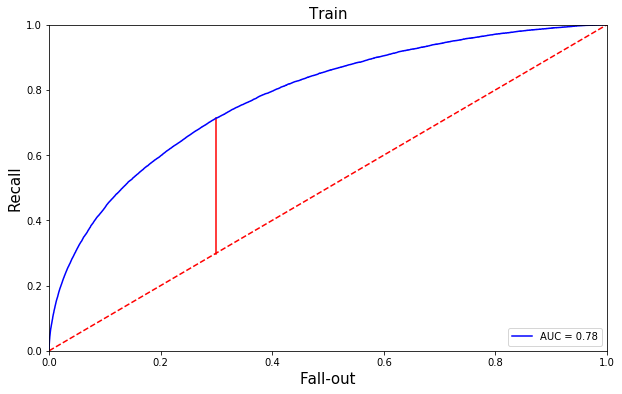

AUC:  0.7801522351479604
KS:  0.41408956089195


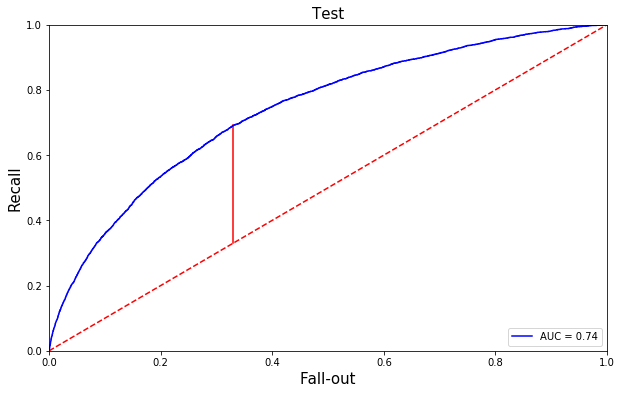

AUC:  0.7387034279337683
KS:  0.3610455139076643


In [13]:
from sklearn.ensemble import RandomForestClassifier

# model training
model = RandomForestClassifier(max_depth=9,n_estimators=100)
model.fit(X_train, y_train)

# output probability
y_hat = model.predict_proba(X_train)[:,1]
y_pred = model.predict_proba(X_test)[:,1]

# evaluation
ev.plot_ROC(y_train, y_hat, 'Train')
ev.plot_ROC(y_test, y_pred, 'Test')